# Cell2Fate analysis of mouse dentate gyrus dataset

This notebook demonstrates Cell2Fate analysis on the mouse dentate gyrus dataset.

Based on: https://cell2fate.readthedocs.io/en/latest/notebooks/publication_figures/cell2fate_DentateGyrus.html


In [2]:
import cell2fate as c2f
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os

data_name = 'DentateGyrus'


Global seed set to 0


## Set up data directories

You need to change this to suitable directories on your system:


In [3]:
# where to download data and where to save results
data_path = './data/DentateGyrus/'
results_path = './results/DentateGyrus/'

# Create directories if they don't exist
os.makedirs(data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)


## Download data


In [4]:
# Downloading data into specified directory:
os.system('cd ' + data_path + ' && wget -q https://cell2fate.cog.sanger.ac.uk/' + data_name + '/' + data_name + '_anndata.h5ad')


0

## Load data and extract most variable genes

Load the data and extract most variable genes (and optionally remove some clusters).


In [28]:
adata = sc.read_h5ad(data_path + data_name + '_anndata.h5ad')
background = adata.var_names
clusters_to_remove = []
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**5, cluster_column = 'clusters',
                                    remove_clusters = clusters_to_remove,
                                min_shared_counts = 20, n_var_genes= 3000)


Keeping at most 100000 cells per cluster
Filtered out 10340 genes that are detected 20 counts (shared).
Extracted 3000 highly variable genes.


In [29]:
adata.shape

(2930, 3000)

In [30]:
adata

AnnData object with n_obs × n_vars = 2930 × 3000
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

## overview of the data by UMAP on 

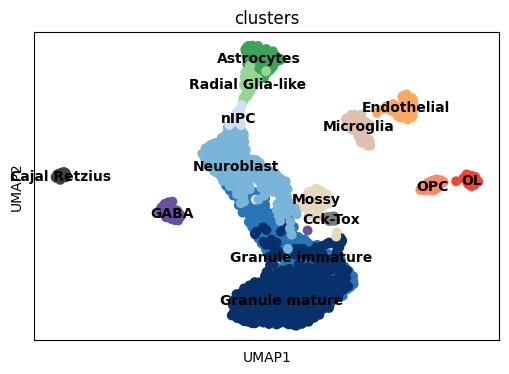

In [31]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data', show = False, ax = ax)
plt.savefig(results_path + data_name + 'UMAP_clusters.pdf')
plt.show()


## Dimensionality Reduction: PCA

Let's reduce the 3000 genes down to ? latent features using PCA first.


Number of PCs needed for 80% variance: 83


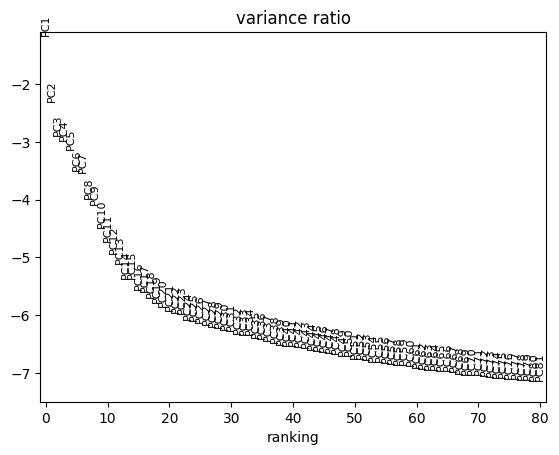

In [11]:
# Let's try 80 PCs for PCA, based on the estimated need (~72)
sc.pp.pca(adata, n_comps=100, svd_solver='arpack')

# Compute cumulative explained variance
cumvar = np.cumsum(adata.uns['pca']['variance_ratio'])

# Check how many PCs are needed to reach 80% variance explained
if cumvar[-1] >= 0.8:
    n_pcs_80 = np.where(cumvar > 0.8)[0][0] + 1
    print(f"Number of PCs needed for 80% variance: {n_pcs_80}")
else:
    print(f"80% variance NOT reached with 80 PCs")
    print(f"Variance explained by 80 PCs: {cumvar[-1]:.2%}")
    # Estimate how many PCs we'd need
    variance_per_pc = adata.uns['pca']['variance_ratio']
    avg_var = np.mean(variance_per_pc[-10:])  # Average of last 10 PCs
    remaining_var = 0.8 - cumvar[-1]
    estimated_pcs = int(remaining_var / avg_var) + 80
    print(f"Estimated PCs needed for 80%: ~{estimated_pcs}")

# Visualize variance explained
sc.pl.pca_variance_ratio(adata, n_pcs=80, log=True)


In [12]:

"""Extract top 20 PCA components as latent matrix"""

import pandas as pd

n_latent = 20
pca_latent = adata.obsm['X_pca'][:, :n_latent]

# Create DataFrame for easier manipulation
pca_df = pd.DataFrame(
    pca_latent,
    columns=[f'PC{i+1}' for i in range(n_latent)],
    index=adata.obs_names
)

print(f"PCA Latent Matrix Shape: {pca_df.shape}")
print(f"\nFirst few rows:")
print(pca_df.head())

# Add cluster info
pca_df['cluster'] = adata.obs['clusters'].values
print(f"\nVariance explained by top {n_latent} PCs: {cumvar[n_latent-1]:.2%}")


PCA Latent Matrix Shape: (2930, 20)

First few rows:
                        PC1         PC2         PC3         PC4         PC5  \
index                                                                         
AAATCTGAAGCCTA   690.214233   64.034012 -127.448715  314.946198   86.315346   
AACAGAGACGAATC   862.432068  126.144943 -103.622307  296.021851   95.614296   
AACGCCCTCATTGG   444.574463   42.412102 -103.663544  290.602631  120.842339   
AACGTTCTTCCCAC   812.733398   10.032089  -98.825302  236.167023   66.479408   
AACTTGCTTACTTC  1593.569336  198.851242  -99.457870  249.687622   40.244415   

                       PC6        PC7         PC8         PC9        PC10  \
index                                                                       
AAATCTGAAGCCTA -101.187927 -46.516716 -249.657150   46.111053  -29.823725   
AACAGAGACGAATC -136.355148 -27.662933 -158.529144    2.623513 -185.213394   
AACGCCCTCATTGG -140.476593 -25.735680 -168.758606 -110.035378  -59.408676   
AACGTTCT

In [13]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,cluster
index,,,,,,,,,,,,,,,,,,,,,
AAATCTGAAGCCTA,690.214233,64.034012,-127.448715,314.946198,86.315346,-101.187927,-46.516716,-249.657150,46.111053,-29.823725,...,-8.676532,-47.971947,-9.679896,12.028729,4.505049,-37.457619,38.560909,17.221735,-31.213421,Astrocytes
AACAGAGACGAATC,862.432068,126.144943,-103.622307,296.021851,95.614296,-136.355148,-27.662933,-158.529144,2.623513,-185.213394,...,28.616257,11.078829,-2.338774,-42.218513,27.994831,44.350132,-80.221893,-40.095123,16.009228,Astrocytes
AACGCCCTCATTGG,444.574463,42.412102,-103.663544,290.602631,120.842339,-140.476593,-25.735680,-168.758606,-110.035378,-59.408676,...,65.518181,-35.625767,20.228329,-11.433114,9.784079,46.878529,-66.925392,-25.749754,49.762917,Astrocytes
AACGTTCTTCCCAC,812.733398,10.032089,-98.825302,236.167023,66.479408,-74.740311,-22.529295,-180.667831,-18.613398,39.781723,...,88.791199,-18.772120,-1.745320,22.629593,-6.333866,-34.067863,33.621666,-7.263849,-10.689816,Astrocytes
AACTTGCTTACTTC,1593.569336,198.851242,-99.457870,249.687622,40.244415,-66.599174,-61.799595,-98.385597,180.620651,-100.124252,...,13.896084,76.924477,-8.278091,19.213514,-4.497755,-12.775043,-53.204021,-46.082718,71.174599,Astrocytes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCCTATGAACGCTA,-10.261209,-301.673492,6.500479,-61.206734,98.407318,-36.335510,-85.860252,-27.110050,-91.667801,-26.833427,...,-50.233109,192.490540,39.000938,15.533714,38.331146,23.316715,-22.180780,9.847828,-41.222672,nIPC
TTACGTACATGACC,-13.264440,-208.194229,-40.907669,46.419807,71.116653,-17.403194,-39.663563,-26.684441,-100.859291,59.220181,...,-70.131088,162.134384,43.950619,20.429871,63.806328,66.001068,2.194355,-13.581532,16.001785,nIPC
TTAGGGTGCCTTGC,11.948863,-230.233276,-14.393474,-3.476644,96.033928,-46.655441,-69.067047,16.377632,-136.446823,23.228197,...,-41.110226,179.766708,39.808941,-12.607962,68.939850,-20.508101,-76.857681,-9.543716,-105.331696,nIPC


## Dimensionality Reduction: NMF (Non-negative Matrix Factorization)

Now let's use NMF to find interpretable gene programs. NMF is better suited for gene expression data because:
- All values are non-negative (matches biological reality)
- Finds additive "gene programs" (co-expressed gene modules)
- More interpretable than PCA


with:

n_components=20, 

In [14]:
from sklearn.decomposition import NMF

# NMF works on non-negative data (perfect for gene expression)
# Convert sparse matrix to dense if needed
X_dense = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X

# Initialize and fit NMF
print("Fitting NMF model (this may take a few minutes)...")
nmf = NMF(
    n_components=20, 
    init='nndsvda',  # Non-negative double SVD initialization
    random_state=42,
    max_iter=500,
    verbose=1
)

# Fit and transform
nmf_latent = nmf.fit_transform(X_dense)

# Store in adata
adata.obsm['X_nmf'] = nmf_latent

print(f"\nNMF completed!")
print(f"Reconstruction error: {nmf.reconstruction_err_:.2f}")


Fitting NMF model (this may take a few minutes)...
violation: 1.0
violation: 0.1817730680820757
violation: 0.21336251255185648
violation: 0.13850172256349164
violation: 0.1098564361723117
violation: 0.09178441619930092
violation: 0.0798584297039699
violation: 0.06927319213502073
violation: 0.05934678003805656
violation: 0.05078519861612786
violation: 0.04409180056085801
violation: 0.03898819500032241
violation: 0.03491930354640947
violation: 0.032147923743635023
violation: 0.030624743915011226
violation: 0.02905835919480737
violation: 0.028051266506198907
violation: 0.027300055075848078
violation: 0.026648355807408142
violation: 0.02635614458339576
violation: 0.026081375615904765
violation: 0.025831896414317726
violation: 0.025573866324586424
violation: 0.025287554983634403
violation: 0.024850190134127394
violation: 0.02431439933546025
violation: 0.023694537553701597
violation: 0.02282657411699085
violation: 0.021954114169315798
violation: 0.02088856323158544
violation: 0.0197237812566

In [17]:
# Evaluate NMF quality
# Calculate what percentage of the data is reconstructed

# Reconstruction
X_reconstructed = nmf_latent @ nmf.components_

# Calculate metrics
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(X_dense, X_reconstructed)
r2 = r2_score(X_dense.flatten(), X_reconstructed.flatten())

# Frobenius norm (total magnitude of the data)
original_norm = np.linalg.norm(X_dense, 'fro')
reconstruction_norm = np.linalg.norm(X_reconstructed, 'fro')
error_norm = np.linalg.norm(X_dense - X_reconstructed, 'fro')

print("=" * 60)
print("NMF QUALITY METRICS")
print("=" * 60)
print(f"Reconstruction error: {nmf.reconstruction_err_:.2f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"\nRelative reconstruction error: {error_norm/original_norm:.4f}")
print(f"  (lower is better, 0 = perfect reconstruction)")
print(f"\nPercentage of variance explained: {r2*100:.2f}%")
print("=" * 60)

if r2 > 0.5:
    print("✅ Good reconstruction! NMF captured major patterns.")
elif r2 > 0.3:
    print("⚠️  Moderate reconstruction. Consider more components.")
else:
    print("❌ Poor reconstruction. May need more components or different approach.")


NMF QUALITY METRICS
Reconstruction error: 15930.88
Mean Squared Error: 28.8970
R² Score: 0.8194

Relative reconstruction error: 0.4151
  (lower is better, 0 = perfect reconstruction)

Percentage of variance explained: 81.94%
✅ Good reconstruction! NMF captured major patterns.


In [18]:

# Create DataFrame for NMF latent matrix
nmf_df = pd.DataFrame(
    nmf_latent,
    columns=[f'Program{i+1}' for i in range(20)],
    index=adata.obs_names
)

print(f"NMF Latent Matrix Shape: {nmf_df.shape}")
print(f"\nFirst few rows:")
print(nmf_df.head())

# Add cluster info
nmf_df['cluster'] = adata.obs['clusters'].values


NMF Latent Matrix Shape: (2930, 20)

First few rows:
                Program1  Program2  Program3  Program4  Program5  Program6  \
index                                                                        
AAATCTGAAGCCTA  0.286978  0.129822  0.027990   0.00000  0.000000  0.000000   
AACAGAGACGAATC  0.481550  0.176743  0.000000   0.00000  0.000000  0.014392   
AACGCCCTCATTGG  0.507615  0.078069  0.000000   0.00036  0.004189  0.000000   
AACGTTCTTCCCAC  0.123612  0.174339  0.024509   0.00000  0.001224  0.023632   
AACTTGCTTACTTC  0.243661  0.371949  0.000000   0.00000  0.000000  0.000000   

                Program7  Program8  Program9  Program10  Program11  Program12  \
index                                                                           
AAATCTGAAGCCTA  0.000000  0.000000  0.603080   0.029936   0.000000   0.040872   
AACAGAGACGAATC  0.020859  0.000000  0.622849   0.182902   0.000000   0.000000   
AACGCCCTCATTGG  0.033119  0.005261  0.313501   0.145255   0.000000   0.60220

In [19]:
nmf_df

,Program1,Program2,Program3,Program4,Program5,Program6,Program7,Program8,Program9,Program10,...,Program12,Program13,Program14,Program15,Program16,Program17,Program18,Program19,Program20,cluster
index,,,,,,,,,,,,,,,,,,,,,
AAATCTGAAGCCTA,0.286978,0.129822,0.027990,0.000000,0.000000,0.000000,0.000000,0.000000,0.603080,0.029936,...,0.040872,0.000000,0.000000,0.000000,0.003598,0.000000,0.053895,0.000000,0.000000,Astrocytes
AACAGAGACGAATC,0.481550,0.176743,0.000000,0.000000,0.000000,0.014392,0.020859,0.000000,0.622849,0.182902,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.121409,Astrocytes
AACGCCCTCATTGG,0.507615,0.078069,0.000000,0.000360,0.004189,0.000000,0.033119,0.005261,0.313501,0.145255,...,0.602206,0.000000,0.000208,0.000000,0.019283,0.031561,0.000000,0.032243,0.000000,Astrocytes
AACGTTCTTCCCAC,0.123612,0.174339,0.024509,0.000000,0.001224,0.023632,0.049404,0.003760,0.224270,0.000000,...,0.744445,0.000000,0.000000,0.001758,0.011066,0.013839,0.041849,0.053214,0.000000,Astrocytes
AACTTGCTTACTTC,0.243661,0.371949,0.000000,0.000000,0.000000,0.000000,0.040007,0.012586,0.553580,0.001409,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001772,0.000000,0.000645,Astrocytes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCCTATGAACGCTA,0.154052,0.005071,0.288743,0.000190,0.004322,0.107249,0.033676,0.003961,0.008207,0.086521,...,0.014828,0.001561,0.000000,0.000000,0.014471,0.134035,0.069254,0.000000,1.883299,nIPC
TTACGTACATGACC,0.184373,0.001105,0.063084,0.000000,0.001121,0.055372,0.017960,0.002857,0.018040,0.051019,...,0.077381,0.002162,0.002419,0.000000,0.015134,0.152401,0.104437,0.007780,0.839026,nIPC
TTAGGGTGCCTTGC,0.255007,0.009538,0.070915,0.000280,0.000000,0.071857,0.039136,0.003525,0.004513,0.104433,...,0.080173,0.003350,0.001745,0.000000,0.015361,0.098386,0.081388,0.000000,1.912873,nIPC


In [20]:
# Interpret gene programs by examining top contributing genes
print("=" * 80)
print("TOP 10 GENES FOR EACH NMF PROGRAM")
print("=" * 80)

for i in range(20):
    # Get gene loadings for this program
    gene_loadings = nmf.components_[i]
    
    # Get indices of top 10 genes
    top_gene_idx = gene_loadings.argsort()[-10:][::-1]
    top_genes = adata.var_names[top_gene_idx]
    top_weights = gene_loadings[top_gene_idx]
    
    print(f"\n📊 Program {i+1}:")
    for gene, weight in zip(top_genes, top_weights):
        print(f"   {gene:15s} (weight: {weight:.3f})")
    print("-" * 80)


TOP 10 GENES FOR EACH NMF PROGRAM

📊 Program 1:
   Fth1            (weight: 250.829)
   Ubb             (weight: 12.838)
   Ptma            (weight: 7.091)
   Sepw1           (weight: 5.329)
   Eif1            (weight: 5.183)
   Eef1a1          (weight: 4.322)
   Sec11c          (weight: 3.464)
   Actb            (weight: 2.695)
   Zfp706          (weight: 2.515)
   Aplp1           (weight: 2.397)
--------------------------------------------------------------------------------

📊 Program 2:
   Cst3            (weight: 3988.387)
   Hexb            (weight: 178.079)
   Itm2b           (weight: 106.187)
   Eef1a1          (weight: 60.016)
   H3f3b           (weight: 55.386)
   Lgmn            (weight: 54.115)
   P2ry12          (weight: 48.462)
   Ubb             (weight: 43.445)
   Rnaset2b        (weight: 36.382)
   Psap            (weight: 33.890)
--------------------------------------------------------------------------------

📊 Program 3:
   Tmsb10          (weight: 417.432)
   Tmsb4

## Comparison: PCA vs NMF

Let's visualize how cells are represented in both latent spaces.


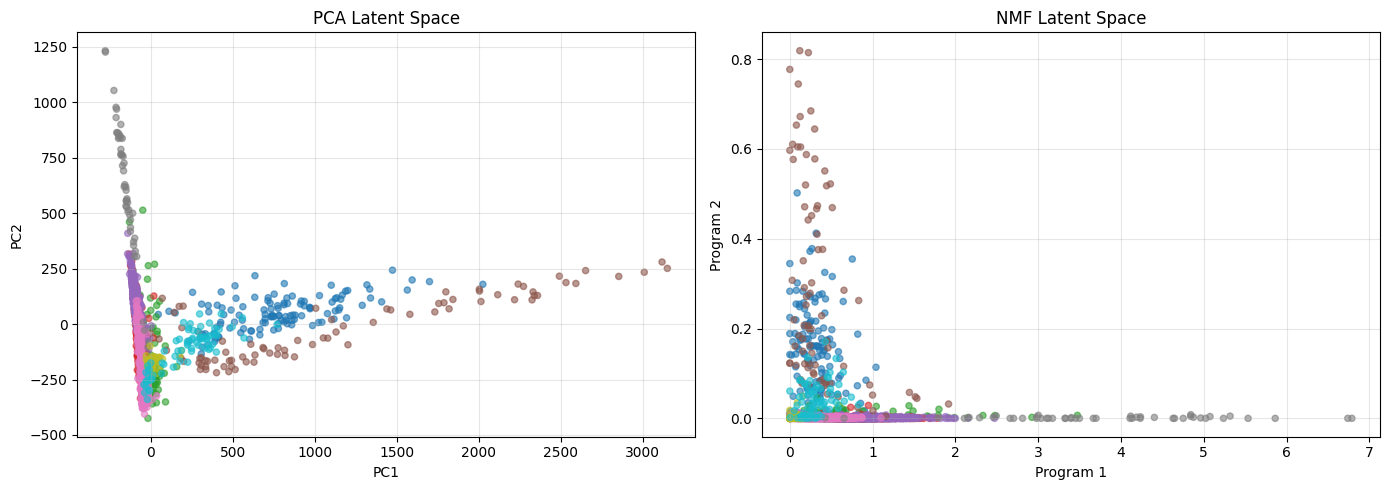


Key differences:
- PCA: Components can have negative values (bidirectional)
- NMF: All values are non-negative (additive gene programs)


In [22]:
# Visualize first 2 components of PCA vs NMF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PCA
axes[0].scatter(pca_df['PC1'], pca_df['PC2'], 
               c=pca_df['cluster'].astype('category').cat.codes, 
               cmap='tab10', s=20, alpha=0.6)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('PCA Latent Space')
axes[0].grid(True, alpha=0.3)

# NMF
axes[1].scatter(nmf_df['Program1'], nmf_df['Program2'], 
               c=nmf_df['cluster'].astype('category').cat.codes,
               cmap='tab10', s=20, alpha=0.6)
axes[1].set_xlabel('Program 1')
axes[1].set_ylabel('Program 2')
axes[1].set_title('NMF Latent Space')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_path + 'PCA_vs_NMF_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("\nKey differences:")
print("- PCA: Components can have negative values (bidirectional)")
print("- NMF: All values are non-negative (additive gene programs)")


## UMAP comparison between PCA and NMF latent spaces


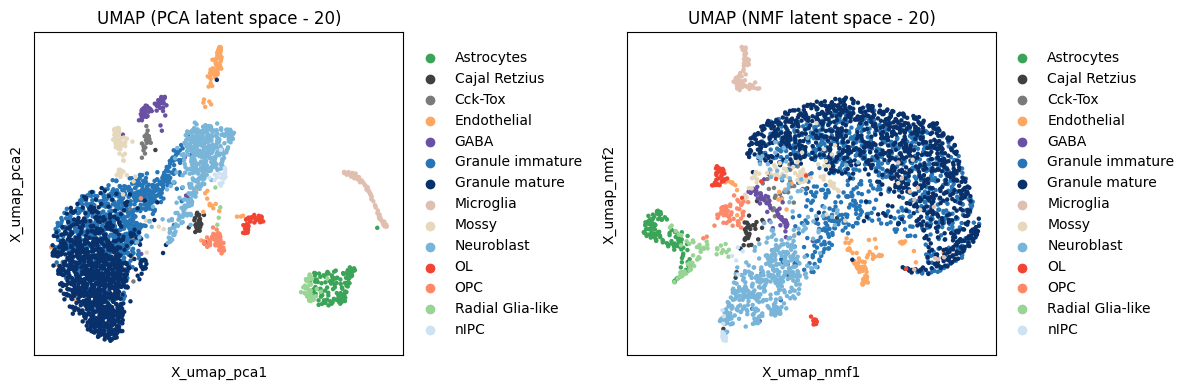

In [27]:
# Compare UMAP embeddings derived from PCA vs NMF latent spaces
if 'neighbors_pca' not in adata.uns:
    sc.pp.neighbors(
        adata,
        use_rep='X_pca',
        n_neighbors=15,
        key_added='neighbors_pca'
    )

if 'neighbors_nmf' not in adata.uns:
    sc.pp.neighbors(
        adata,
        use_rep='X_nmf',
        n_neighbors=15,
        key_added='neighbors_nmf'
    )

pca_umap = sc.tl.umap(adata, neighbors_key='neighbors_pca', copy=True)
nmf_umap = sc.tl.umap(adata, neighbors_key='neighbors_nmf', copy=True)
adata.obsm['X_umap_pca'] = pca_umap.obsm['X_umap']
adata.obsm['X_umap_nmf'] = nmf_umap.obsm['X_umap']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sc.pl.embedding(
    adata,
    basis='X_umap_pca',
    color='clusters',
    ax=axes[0],
    show=False,
    title='UMAP (PCA latent space - 20)'
)
sc.pl.embedding(
    adata,
    basis='X_umap_nmf',
    color='clusters',
    ax=axes[1],
    show=False,
    title='UMAP (NMF latent space - 20)'
)
plt.tight_layout()
plt.savefig(results_path + 'UMAP_PCA_vs_NMF.pdf', dpi=300, bbox_inches='tight')
plt.show()

